In [1]:
import pandas as pd
import numpy as np

In [3]:
train = pd.read_parquet("/kaggle/input/drw-crypto-market-prediction/train.parquet")
test = pd.read_parquet("/kaggle/input/drw-crypto-market-prediction/test.parquet")

In [4]:
train.head()

,bid_qty,ask_qty,buy_qty,sell_qty,volume,X1,X2,X3,X4,X5,...,X882,X883,X884,X885,X886,X887,X888,X889,X890,label
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-03-01 00:00:00,15.283,8.425,176.405,44.984,221.389,0.121263,-0.417690,0.005399,0.125948,0.058359,...,1.925423,1.847943,0.005676,0.190791,0.369691,0.377630,0.210153,0.159183,0.530636,0.562539
2023-03-01 00:01:00,38.590,2.336,525.846,321.950,847.796,0.302841,-0.049576,0.356667,0.481087,0.237954,...,1.928569,1.849468,0.005227,0.184660,0.363642,0.374515,0.209573,0.158963,0.530269,0.533686
2023-03-01 00:02:00,0.442,60.250,159.227,136.369,295.596,0.167462,-0.291212,0.083138,0.206881,0.101727,...,1.928047,1.849282,0.004796,0.178719,0.357689,0.371424,0.208993,0.158744,0.529901,0.546505
2023-03-01 00:03:00,4.865,21.016,335.742,124.963,460.705,0.072944,-0.436590,-0.102483,0.017551,0.007149,...,1.928621,1.849608,0.004398,0.172967,0.351832,0.368358,0.208416,0.158524,0.529534,0.357703
2023-03-01 00:04:00,27.158,3.451,98.411,44.407,142.818,0.173820,-0.213489,0.096067,0.215709,0.107133,...,1.927084,1.848950,0.004008,0.167391,0.346066,0.365314,0.207839,0.158304,0.529167,0.362452


In [ ]:
cols = [f"X{i}" for i in range(1,891)]

X = train[cols].copy()                  # keep the original df intact
X = X.dropna()                       # simplest missing-value policy
X = X.to_numpy(dtype='float32')
X = np.where(np.isneginf(X), -1000, X)


X_ = test[cols].copy()                  # keep the original df intact
X_ = X_.dropna()                       # simplest missing-value policy
X_ = X_.to_numpy(dtype='float32')
X_ = np.where(np.isneginf(X_), -1000, X_)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_std = scaler.fit_transform(X)      # ndarray, same rows/cols order
X_std_ = scaler.transform(X_)      # ndarray, same rows/cols order

In [6]:
# from sklearn.decomposition import PCA
# import matplotlib.pyplot as plt

# pca = PCA(n_components=0.99)  # retain 95% of variance (or set to int like 20)
# X_pca = pca.fit_transform(X_std)

In [7]:
# X_pca_ = pca.transform(X_std_)

In [8]:
# train.drop(cols, axis =1, inplace= True)

In [9]:
# test.drop(cols, axis =1, inplace= True)

In [7]:
# train[[f"X{i}" for i in range(1,326)]] =X_pca

In [8]:
# test[[f"X{i}" for i in range(1,326)]] =X_pca_

In [9]:
y_train = train["label"]
y_test = test["label"]
X_train = train.drop(["label"], axis = 1)
X_test = test.drop(["label"], axis = 1)

In [10]:
train['past_label'] = train['label'].shift(1)

In [11]:
BASE = ['bid_qty', 'ask_qty', 'buy_qty', 'sell_qty', 'volume']     # add chosen X-cols
LAGS = [1, 2, 5, 10, 30]           # 1 min … 30 min
WINS = {'15m': 15, '2h': 120, '6h': 360}

for col in BASE:
    # simple lags
    for l in LAGS:
        train[f'{col}_lag{l}'] = train[col].shift(l)

    # rolling stats (shift first ➜ leak-free)
    past = train[col].shift(1)
    for tag, w in WINS.items():
        roll = past.rolling(w, min_periods=w)
        train[f'{col}_mean_{tag}'] = roll.mean()
        train[f'{col}_std_{tag}']  = roll.std()


In [12]:
train['qty_imbalance'] = (train['bid_qty'] - train['ask_qty']) / (train['bid_qty'] + train['ask_qty'] + 1e-6)
train['buy_sell_ratio'] = (train['buy_qty'] + 1) / (train['sell_qty'] + 1)

# add a 1-lag so it’s legal
train['qty_imbalance_lag1'] = train['qty_imbalance'].shift(1)

In [ ]:
warmup = max(WINS.values())        # 360 if 6-hour window
train = train.iloc[warmup:].copy()       # remove rows with NaNs from rolling windows

FEATURES = [c for c in train.columns if c not in ('label', 'past_label')]
X_final  = train[FEATURES].astype('float32')   # down-cast for memory
y_final  = train['label'].astype('float32')


In [21]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3, test_size=120_000, gap=10_000)

for k, (tr, va) in enumerate(tscv.split(X_final)):
    print(f'Fold {k}: train {tr.size}, val {va.size}')

Fold 0: train 155527, val 120000
Fold 1: train 275527, val 120000
Fold 2: train 395527, val 120000


In [22]:
import lightgbm as lgb, numpy as np

params = dict(
    objective='regression',
    n_estimators=400,
    learning_rate=0.05,
    num_leaves=128,
    subsample=0.6,
    colsample_bytree=0.6,
    min_data_in_leaf=200,
    seed=42
)

fold_scores = []
for tr, va in tscv.split(X_final):
    mdl = lgb.LGBMRegressor(**params)
    mdl.fit(X_final.iloc[tr], y_final.iloc[tr])
    pred = mdl.predict(X_final.iloc[va])

    # Pearson (competition metric)
    s = np.corrcoef(pred, y_final.iloc[va])[0, 1]
    fold_scores.append(s)
    print(f'Fold Pearson: {s:.4f}')

print('CV mean:', np.mean(fold_scores))

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.448755 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98940
[LightGBM] [Info] Number of data points in the train set: 155527, number of used features: 388
[LightGBM] [Info] Start training from score 0.003294
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
Fold Pearson: 0.0699
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [In

In [23]:
# does y_train line up with X_train.index ?
display(X_train.index[:3], y_train.index[:3])

# sanity: naive “repeat-previous” predictor
naive = y_train.shift(1).iloc[1:]
print('Naive Pearson', naive.corr(y_train.iloc[1:]))

DatetimeIndex(['2023-03-01 00:00:00', '2023-03-01 00:01:00',
               '2023-03-01 00:02:00'],
              dtype='datetime64[ns]', name='timestamp', freq=None)

DatetimeIndex(['2023-03-01 00:00:00', '2023-03-01 00:01:00',
               '2023-03-01 00:02:00'],
              dtype='datetime64[ns]', name='timestamp', freq=None)

Naive Pearson 0.9811953720097024


In [27]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error

In [28]:
y = train['label'].astype(float)
y = y.asfreq('T')

/tmp/ipykernel_95/1087427844.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  y = y.asfreq('T')


In [20]:
const_cols = [c for c in train.columns if train[c].nunique()==1]; train.drop(columns=const_cols, inplace=True)

[]

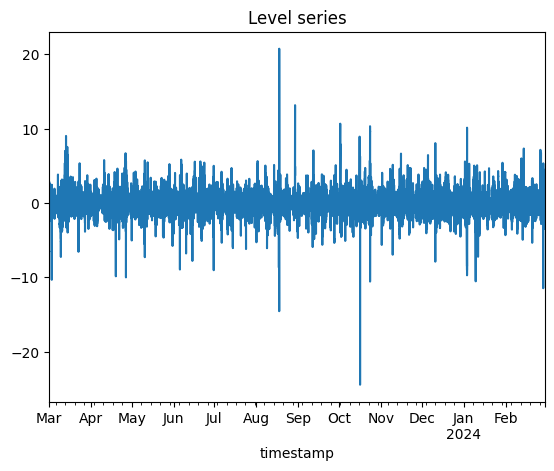

In [29]:
y.plot(title="Level series")
plt.show()

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


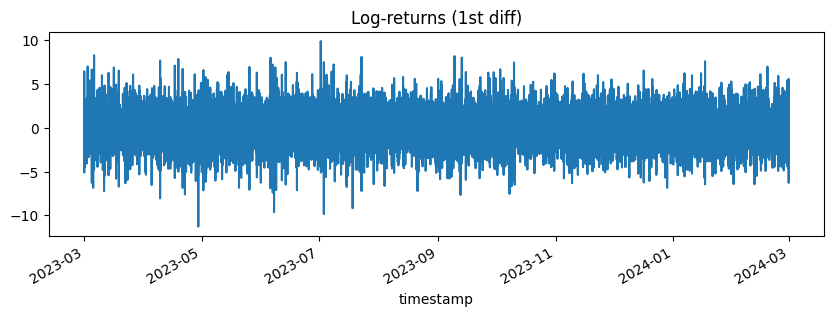

In [ ]:
y_log = np.log(y)
y_diff = y_log.diff().dropna()     # 1st difference = log-return

fig, ax = plt.subplots(1, 1, figsize=(10, 3))
y_diff.plot(ax=ax, title="Log-returns (1st diff)")
plt.show()

# -------------------------
# 4. Stationarity test
# -------------------------
adf_stat, p_val, *_ = adfuller(y_diff)
print(f"ADF statistic: {adf_stat:.3f},  p-value: {p_val:.4f}")

# -------------------------
# 5. ACF / PACF on diff
# -------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
plot_acf(y_diff, lags=120, zero=False, ax=ax1)
plot_pacf(y_diff, lags=120, zero=False, ax=ax2)
ax1.set_title("ACF (log-diff)")
ax2.set_title("PACF (log-diff)")
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller, kpss, PhillipsPerron

def print_test(name, stat, p):
    print(f"{name:<18} statistic = {stat:8.3f} | p-value = {p:7.4f} "
          + ("→ reject H₀ (stationary)" if p < 0.05 else "→ fail to reject H₀"))

adf_stat, adf_p, *_ = adfuller(y_diff, regression='c')    # H₀: unit root
kpss_stat, kpss_p, *_ = kpss(y_diff, regression='c')     # H₀: stationary
pp = PhillipsPerron(y_diff)
print_test("ADF", adf_stat, adf_p)
print_test("KPSS", kpss_stat, kpss_p)
print_test("Phillips-Perron", pp.stat, pp.pvalue)

In [24]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(
    n_splits=4,
    test_size=120_000,   # tweak so each fold ≈ 1 month
    gap=10_000           # avoid leakage across fold boundary
)

features = [c for c in train.columns if c not in ['target','timestamp','row_id']]
for f,(tr,va) in enumerate(tscv.split(train)):
    print(f, tr.min(), tr.max(), '→', va.min(), va.max())

0 0 35886 → 45887 165886
1 0 155886 → 165887 285886
2 0 275886 → 285887 405886
3 0 395886 → 405887 525886


AttributeError: 'TimeSeriesSplit' object has no attribute 'head'

In [14]:
from sklearn.linear_model import LinearRegression   # swap for any regressor

reg = LinearRegression()

reg.fit(X_train, y_train)

y_pred_train = reg.predict(X_train)

from sklearn.metrics import mean_squared_error, r2_score
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
r2_train   = r2_score(y_train, y_pred_train)

print(f"Train RMSE: {rmse_train:,.3f}")
print(f"Train R² : {r2_train:,.3f}")


Train RMSE: 0.970
Train R² : 0.078


In [15]:
train

,bid_qty,ask_qty,buy_qty,sell_qty,volume,label,X1,X2,X3,X4,...,X316,X317,X318,X319,X320,X321,X322,X323,X324,X325
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-03-01 00:00:00,15.283,8.425,176.405,44.984,221.389,0.562539,8.746063,5.333962,-0.124114,7.537787,...,-0.270940,0.229016,0.468283,0.377931,-0.389617,-0.191084,0.243104,0.323700,0.018024,-0.031501
2023-03-01 00:01:00,38.590,2.336,525.846,321.950,847.796,0.533686,8.058016,5.407232,0.090197,4.767918,...,-0.484063,0.533242,0.511868,0.322164,-0.471900,-0.341821,0.313885,0.177279,-0.002565,-0.129196
2023-03-01 00:02:00,0.442,60.250,159.227,136.369,295.596,0.546505,8.280668,4.985713,0.173206,4.019284,...,-0.458561,0.292894,0.395871,0.366317,-0.552569,-0.343551,0.243277,0.285505,-0.051866,0.106529
2023-03-01 00:03:00,4.865,21.016,335.742,124.963,460.705,0.357703,6.639946,7.388400,0.997532,5.047791,...,-0.353293,0.040080,0.463196,0.231862,-0.394011,-0.287132,0.157896,0.247189,-0.106108,-0.075019
2023-03-01 00:04:00,27.158,3.451,98.411,44.407,142.818,0.362452,6.526500,7.030857,0.551639,5.286619,...,-0.313321,0.148964,0.415908,0.295884,-0.331883,-0.220041,0.104404,0.184793,-0.109534,-0.086322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-29 23:55:00,4.163,6.805,39.037,55.351,94.388,0.396289,4.454558,-3.244024,4.160742,-3.094408,...,0.072375,0.205947,-0.002942,0.296833,0.429195,-0.814831,-0.210432,0.419000,-0.178965,-0.337217
2024-02-29 23:56:00,2.290,4.058,110.201,67.171,177.372,0.328993,3.294380,-3.196732,3.540385,-2.862762,...,0.055805,0.167304,0.010960,0.299207,0.546627,-0.784082,-0.138464,0.394921,-0.304073,-0.350017
2024-02-29 23:57:00,5.237,3.640,70.499,30.753,101.252,0.189909,1.808636,-1.733403,4.607615,-1.765359,...,-0.012307,0.226388,0.161700,0.231687,0.168770,-0.665137,0.035786,0.364957,-0.131672,-0.172019
